In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.io
from scipy.io import loadmat 
import scipy.linalg as la

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score

!pip install mne
import mne
from mne.datasets import sample
from mne import io, EvokedArray
from mne.decoding import Vectorizer, get_coef, LinearModel, GeneralizingEstimator, CSP

# PCA On X

In [3]:
data = loadmat('doi_10.5061_dryad.dbrv15f0j__v4/ImageryData.mat', squeeze_me = True)

In [4]:
# Function: Returns EEG trial data for selected trial, condition, and participant
def pull_participant(prpt_num, condition, trial_num, dataset = data):
    # Prpt_num: Between 0 and 20
    # Condition: 0 or 1
    # Trial_num: 0 to 43
    return dataset['eeg'][prpt_num][condition][trial_num]

In [5]:
# Example: Participant 1, Condition 1, Trial 1
p1_c1_t1 = pull_participant(0, 0, 0)
p1_c1_t1

array([[  664.72560828,   774.98985086,   390.62433311, ...,
         -245.7771578 ,  -235.98898479,  -236.61411997],
       [  743.73913029,   642.26458987,   287.9295975 , ...,
          -92.36065428,  -112.83487091,   -97.30625674],
       [  700.89176637,   782.91181184,   406.26919551, ...,
         -172.79197054,  -197.78535183,  -162.95029308],
       ...,
       [ 4770.29167744,  1952.82409403,  2012.71194821, ...,
        -1195.42151149, -1157.17819489, -1201.28717072],
       [ 4576.31171852,  1766.85097358,  1791.70411971, ...,
         -998.08259617,  -980.14286334,  -999.25659032],
       [ 4563.51962667,  1771.93219765,  1905.09526562, ...,
        -1011.80018565,  -993.00964359, -1034.42898947]])

In [6]:
# Sanity check: DataFrame of EEG data
pd.DataFrame(p1_c1_t1).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,664.725608,774.989851,390.624333,163.803324,126.765475,-68.616649,274.025516,-92.317319,-234.593113,59.197379,...,-358.399090,-554.585428,-262.109573,-242.923448,-353.665009,117.938011,430.055484,-245.777158,-235.988985,-236.614120
1,743.739130,642.264590,287.929597,116.295344,101.258251,-119.957784,264.369912,-94.636482,-271.211650,104.506606,...,-338.333871,-492.820581,-126.902158,-121.350457,-331.037315,147.467710,505.798126,-92.360654,-112.834871,-97.306257
2,700.891766,782.911812,406.269196,273.219591,298.911231,38.354083,348.627741,8.308116,-118.504432,250.810106,...,-367.838493,-515.944722,-185.768440,-195.032035,-409.879564,-34.845585,325.433851,-172.791971,-197.785352,-162.950293
3,717.128672,785.210684,460.916283,389.224373,419.523715,81.835164,439.312572,73.767030,-63.002500,331.728837,...,-469.701298,-615.135800,-306.954268,-305.932186,-495.090066,-120.277455,298.212934,-292.212470,-316.490431,-270.784025
4,606.192455,653.896604,325.209592,251.369839,271.640822,-18.937729,373.647735,-39.387111,-215.207617,188.002201,...,-501.598239,-614.886090,-106.670284,-82.182155,-404.708404,3.906473,476.543611,-79.951120,-101.523353,-37.067790


In [7]:
C = np.dot(np.transpose(p1_c1_t1), p1_c1_t1)

In [8]:
C

array([[ 2.72181620e+09,  1.90249441e+09,  1.24532663e+09, ...,
        -7.41866301e+08, -7.36495388e+08, -7.32399537e+08],
       [ 1.90249441e+09,  1.74879006e+09,  1.02588530e+09, ...,
        -4.68549024e+08, -4.69976434e+08, -4.58288776e+08],
       [ 1.24532663e+09,  1.02588530e+09,  8.80460431e+08, ...,
        -4.15685072e+08, -4.13675274e+08, -4.09742486e+08],
       ...,
       [-7.41866301e+08, -4.68549024e+08, -4.15685072e+08, ...,
         2.99630190e+08,  2.95177773e+08,  2.97384948e+08],
       [-7.36495388e+08, -4.69976434e+08, -4.13675274e+08, ...,
         2.95177773e+08,  2.91547223e+08,  2.93222049e+08],
       [-7.32399537e+08, -4.58288776e+08, -4.09742486e+08, ...,
         2.97384948e+08,  2.93222049e+08,  2.96063692e+08]])

In [9]:
# The outputs are reversed: W is D (kind of), V is P
W, V = np.linalg.eig(C)

In [10]:
# normalize rows of matrix
V = normalize(V, axis=1, norm='l1')

#normalize columns of matrix
V = normalize(V, axis=0, norm='l1')

In [11]:
# array of eigenvalues (not yet diagonalized like D in MATALB version)
W

array([2.40742599e+10, 5.15540331e+09, 3.31737901e+09, 1.92643839e+09,
       8.30550278e+08, 4.00002186e+08, 2.90869944e+08, 2.26782843e+08,
       1.66918515e+08, 1.54289035e+08, 1.09542787e+08, 9.42755034e+07,
       8.20314340e+07, 7.24974341e+07, 6.61954649e+07, 5.21142769e+07,
       4.41652050e+07, 4.01027690e+07, 3.28367604e+07, 3.00829742e+07,
       2.80595160e+07, 2.61875101e+07, 2.20559800e+07, 1.96160614e+07,
       1.71288412e+07, 1.62776553e+07, 1.47455856e+07, 1.35272151e+07,
       1.20593458e+07, 1.13907810e+07, 1.08418706e+07, 9.15449855e+06,
       8.65708030e+06, 8.36639425e+06, 7.31796349e+06, 7.29853605e+06,
       6.33598557e+06, 5.40884902e+06, 4.92259642e+06, 4.61563338e+06,
       4.29951097e+06, 3.88163491e+06, 3.71188753e+06, 3.39850650e+06,
       2.98950154e+06, 2.84970499e+06, 2.07056555e+06, 2.00223187e+06,
       1.85459375e+06, 1.73547844e+06, 1.25016714e+06, 1.49595570e+06,
       1.37387556e+06, 3.69078204e+05, 3.55126596e+05, 2.23437258e+05,
      

In [12]:
# Normalized matrix
V

array([[ 4.38483136e-02,  3.58340178e-02,  8.12102927e-03, ...,
        -8.46134168e-04,  5.21581149e-03,  1.50315928e-04],
       [ 3.24795799e-02,  7.03534503e-02, -9.95289657e-03, ...,
        -1.37338557e-04,  8.27321677e-04, -7.02103652e-04],
       [ 2.29045874e-02,  2.10749155e-02, -3.11612144e-02, ...,
        -1.45509293e-03, -8.64416962e-04,  5.54176907e-04],
       ...,
       [-1.81090548e-02, -7.17922677e-04,  1.11724115e-02, ...,
        -7.45602531e-02,  1.76900926e-01, -7.67664883e-02],
       [-2.00625936e-02, -1.55011742e-03,  1.20052934e-02, ...,
         8.93788704e-02, -7.19603657e-02, -5.86857984e-02],
       [-2.00066608e-02, -3.94879333e-04,  1.22179125e-02, ...,
        -6.28488433e-02,  2.32694474e-02,  8.92728459e-02]])

In [13]:
# Take -1/2 power of all eigenvalues, diagonalize matrix
N = W**(-1/2)
N = np.diag(N)

In [14]:
N

array([[6.44500899e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.39273560e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.73621080e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.87675505e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.91887420e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.90368761e-03]])

In [15]:
Z=np.dot(p1_c1_t1,np.dot(V,N))

In [16]:
Z.shape

(1803, 64)

## Problem
When using the eig() function, eigenvalues are calculated but not in the same position as in MATLAB

# Apply Bias Filter

In [17]:
L=np.zeros((64,1803))
#B=Z*L;
#%covariance of filtered data
#Cfilt = Z'*Z;
#plot (Z, 'DisplayName', 'Z')

In [18]:
L

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
B = np.dot(Z, L)
B

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Covariance of filtered data

In [20]:
Cfilt = np.dot(np.transpose(Z),Z)

Text(0, 0.5, 'Amplitude')

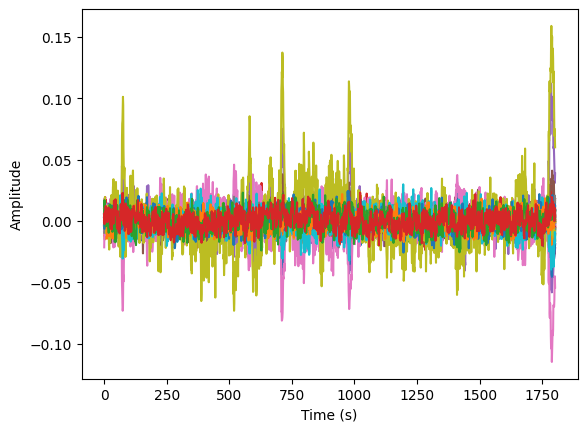

In [26]:
fig, ax = plt.subplots()
ax.plot(Z)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')

# Next Steps
Look into bandpass filters via Python
- https://pypi.org/project/eeg-filters/
- https://neuraldatascience.io/7-eeg/erp_filtering.html